In [ ]:
#imports
from keras.models import Model
from keras.layers import Input, Cropping2D
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras import layers as L
from keras import backend as K
from keras.models import Model
import tensorflow as tf
import numpy as np
from keras.optimizers import Adam
from skimage.measure import label
from scipy.ndimage.morphology import distance_transform_edt
import numpy
import cv2
import matplotlib.pyplot as plt

In [6]:
#defining the model 
class Unet():
    def __init__(self):
        print("Initial U-Net model...")
        self.model = self.initial_model()

    def initial_model(self):
        concat_axis = 3

        input_shape = ((572,572,1))
        output_shape = ((388,388,1))
        n_classes = 1 
        #weight_ip = L.Input(shape=output_shape[:2] + (1,))
        ip = L.Input(shape=input_shape)
        weight_ip = L.Input(output_shape[:2] + (n_classes,))
        targets   = L.Input(output_shape[:2] + (n_classes,))

        #n_classes = 1 

        #weight_ip = L.Input(shape=output_shape[:2] + (1,))

        conv1_1 = Conv2D(64, (3, 3), activation='relu', padding='valid', name='conv1_1')(ip)
        conv1_2 = Conv2D(64, (3, 3), activation='relu', padding='valid', name='conv1_2')(conv1_1)
        pool1 = MaxPooling2D(pool_size=(2, 2), name='maxpooling_1')(conv1_2)

        conv2_1 = Conv2D(128, (3, 3), activation='relu', padding='valid', name='conv2_1')(pool1)
        conv2_2 = Conv2D(128, (3, 3), activation='relu', padding='valid', name='conv2_2')(conv2_1)
        pool2 = MaxPooling2D(pool_size=(2, 2), name='maxpooling_2')(conv2_2)

        conv3_1 = Conv2D(256, (3, 3), activation='relu', padding='valid', name='conv3_1')(pool2)
        conv3_2 = Conv2D(256, (3, 3), activation='relu', padding='valid', name='conv3_2')(conv3_1)
        pool3 = MaxPooling2D(pool_size=(2, 2), name='maxpooling_3')(conv3_2)

        conv4_1 = Conv2D(512, (3, 3), activation='relu', padding='valid', name='conv4_1')(pool3)
        conv4_2 = Conv2D(512, (3, 3), activation='relu', padding='valid', name='conv4_2')(conv4_1)
        pool4 = MaxPooling2D(pool_size=(2, 2), name='maxpooling_4')(conv4_2)

        conv5_1 = Conv2D(1024, (3, 3), activation='relu', padding='valid', name='conv5_1')(pool4)
        conv5_2 = Conv2D(1024, (3, 3), activation='relu', padding='valid', name='conv5_2')(conv5_1)

        upsampling1 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='valid', name='upsampling1')(conv5_2)
        crop_conv4_2 = Cropping2D(cropping=((4, 4), (4, 4)), name='cropped_conv4_2')(conv4_2)
        up6 = concatenate([upsampling1, crop_conv4_2], axis=concat_axis, name='skip_connection1')
        conv6_1 = Conv2D(512, (3, 3), activation='relu', padding='valid', name='conv6_1')(up6)
        conv6_2 = Conv2D(512, (3, 3), activation='relu', padding='valid', name='conv6_2')(conv6_1)

        upsampling2 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='valid', name='upsampling2')(conv6_2)
        crop_conv3_2 = Cropping2D(cropping=((16, 16), (16, 16)), name='cropped_conv3_2')(conv3_2)
        up7 = concatenate([upsampling2, crop_conv3_2], axis=concat_axis, name='skip_connection2')
        conv7_1 = Conv2D(256, (3, 3), activation='relu', padding='valid', name='conv7_1')(up7)
        conv7_2 = Conv2D(256, (3, 3), activation='relu', padding='valid', name='conv7_2')(conv7_1)

        upsampling3 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='valid', name='upsampling3')(conv7_2)
        crop_conv2_2 = Cropping2D(cropping=((40, 40), (40, 40)), name='cropped_conv2_2')(conv2_2)
        up8 = concatenate([upsampling3, crop_conv2_2], axis=concat_axis, name='skip_connection3')
        conv8_1 = Conv2D(128, (3, 3), activation='relu', padding='valid', name='conv8_1')(up8)
        conv8_2 = Conv2D(128, (3, 3), activation='relu', padding='valid', name='conv8_2')(conv8_1)

        upsampling4 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='valid', name='upsampling4')(conv8_2)
        crop_conv1_2 = Cropping2D(cropping=((88, 88), (88, 88)), name='cropped_conv1_2')(conv1_2)
        up9 = concatenate([upsampling4, crop_conv1_2], axis=concat_axis, name='skip_connection4')
        conv9_1 = Conv2D(64, (3, 3), activation='relu', padding='valid', name='conv9_1')(up9)
        conv9_2 = Conv2D(64, (3, 3), activation='relu', padding='valid', name='conv9_2')(conv9_1)

        #conv10 = Conv2D(1, (1, 1), activation='sigmoid', name='conv10')(conv9_2)

        #model = Model(inputs=[inputs], outputs=[conv10])

        c10 = L.Conv2D(1, 1, activation='softmax', kernel_initializer='he_normal' , name='conv10')(conv9_2)
        #c11 = L.Lambda(lambda x: x / tf.reduce_sum(x, len(x.get_shape()) - 1, True))(c10)
        #c11 = L.Lambda(lambda x: tf.clip_by_value(x, _epsilon, 1. - _epsilon))(c11)
        #c11 = L.Lambda(lambda x: K.log(x))(c11)
        #weighted_sm = L.multiply([c11, weight_ip])
        model = Model(ip, c10)

        #model.add_loss(pixel_weighted_cross_entropy(weight_ip, targets, c10))
        
        return model

    def model_summary(self):
        self.model.summary()

    def get_model(self):
        return self.model

In [2]:
unet = Unet()
model = unet.initial_model()

Initial U-Net model...


In [38]:
#customloss function that we need for the following operation
def weighted_bce_loss(y_true, y_pred, weight):
  "This function calculates the pixel wise loss which can be propagated to train the model"
    # avoiding overflow
    epsilon = 1e-7
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    logit_y_pred = K.log(y_pred / (1. - y_pred))
    
    # https://www.tensorflow.org/api_docs/python/tf/nn/weighted_cross_entropy_with_logits
    loss = (1. - y_true) * logit_y_pred + (1. + (weight - 1.) * y_true) * \
    (K.log(1. + K.exp(-K.abs(logit_y_pred))) + K.maximum(-logit_y_pred, 0.))
    return K.sum(loss) / K.sum(weight)

In [3]:
def get_weight_matrix(y, w0, sigma):
  "This functions compute the weight maps of the y(labels) of the current batch that is training"
  weight_maps = np.zeros(y.shape)
  print(weight_maps.shape)
  for i in range(y.shape[0]):
    print(i)
    labels = label(tf.transpose(y[i],perm=[2, 0, 1]))
    no_labels = labels == 0
    label_ids = sorted(numpy.unique(labels))[1:]

    if len(label_ids) > 1:
        distances = numpy.zeros((y[i].shape[0], y[i].shape[1], len(label_ids)))

        for j, label_id in enumerate(label_ids):
            distances[:, :, j] = distance_transform_edt(labels != label_id)

        distances = numpy.sort(distances, axis=2)
        d1 = distances[:, :, 0]
        d2 = distances[:, :, 1]
        w = w0 * numpy.exp(-1 / 2 * ((d1 + d2) / sigma) ** 2) * no_labels
    else:
        w = numpy.zeros_like(y[0])
    w = w.transpose(2,1,0)
    print(i)
    w = w.astype(np.uint8)
    weight_maps[i] = w 
  
  return weight_maps

In [7]:
#optimizer of the model
optimizer = Adam(learning_rate=1e-4)

In [2]:
#loading the data
image_arr = (np.load('/content/drive/MyDrive/nnfl_final_data/imgs_train2.npy'))
tmp_mask = (np.load('/content/drive/MyDrive/nnfl_final_data/imgs_mask_train2.npy'))

In [10]:
#generating the dataset
batch_size = 5
train_dataset = tf.data.Dataset.from_tensor_slices((image_arr, tmp_mask))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

In [ ]:
epochs = 10
for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))

    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        print(y_batch_train.shape)

        # Open a GradientTape to record the operations run
        # during the forward pass, which enables auto-differentiation.
        with tf.GradientTape() as tape:

            # Run the forward pass of the layer.
            # The operations that the layer applies
            # to its inputs are going to be recorded
            # on the GradientTape.
            logits = model(x_batch_train, training=True)  # Logits for this minibatch

            # Compute the loss value for this minibatch.
            loss_value = weighted_bce_loss(y_batch_train, logits, get_weight_matrix(y_batch_train, 10, 5) )

        # Use the gradient tape to automatically retrieve
        # the gradients of the trainable variables with respect to the loss.
        grads = tape.gradient(loss_value, model.trainable_weights)

        # Run one step of gradient descent by updating
        # the value of the variables to minimize the loss.
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        # Log every 200 batches.
        if step % 200 == 0:
            print(
                "Training loss (for one batch) at step %d: %.4f"
                % (step, float(loss_value))
            )
            print("Seen so far: %s samples" % ((step + 1) * 64))

In [ ]:
def get_weight_matrix(y, w0, sigma):
  "This function can be used to generate the weight maps of a single image"
    labels = label(y)
    no_labels = labels == 0
    label_ids = sorted(numpy.unique(labels))[1:]

    if len(label_ids) > 1:
        distances = numpy.zeros((y.shape[0], y.shape[1], len(label_ids)))

        for i, label_id in enumerate(label_ids):
            distances[:, :, i] = distance_transform_edt(labels != label_id)

        distances = numpy.sort(distances, axis=2)
        d1 = distances[:, :, 0]
        d2 = distances[:, :, 1]
        w = w0 * numpy.exp(-1 / 2 * ((d1 + d2) / sigma) ** 2) * no_labels
    else:
        w = numpy.zeros_like(y)
    return w

In [ ]:
#some sample weight maps being plotted 

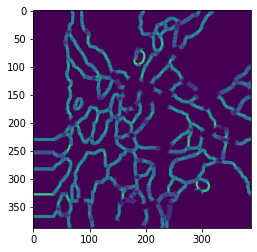

In [9]:
plt.imshow(weight_map[0,:,:,0])

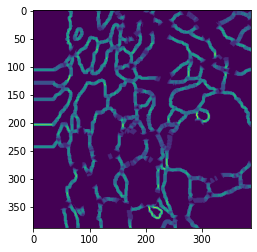

In [10]:
plt.imshow(weight_map[1,:,:,0])

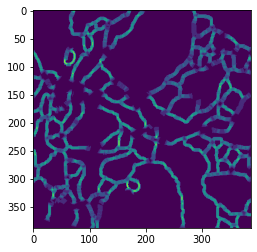

In [11]:
plt.imshow(weight_map[2,:,:,0])

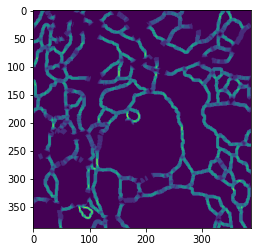

In [12]:
plt.imshow(weight_map[3,:,:,0])

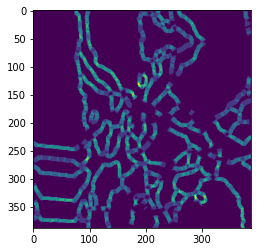

In [13]:
plt.imshow(weight_map[4,:,:,0])